In [1]:
import pandas as pd
import umap
import glob
import numpy as np
import matplotlib.pyplot as plt


import matplotlib.cm as cm

from sklearn.neighbors import NearestNeighbors

from matplotlib import cm

from scipy.ndimage import uniform_filter1d
from scipy.spatial.distance import pdist, squareform

import seaborn as sns

from umap import UMAP

import statsmodels.api as sm

from sklearn.decomposition import PCA



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/ScCal-SLi_left"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
participants_hcp_file = "/neurospin/dico/data/deep_folding/current/datasets/hcp/Handedness/handedness_labels.csv"
participants_imagen_file = "/neurospin/dico/data/deep_folding/current/datasets/imagen/participants.csv"
lab = "Sex"
lab2 = "Age"
lab3 = "Volume"
model_path = glob.glob(f"{path}/*")[0]
ukb_emb_file = f"{model_path}/ukb40_random_epoch80_embeddings/full_embeddings.csv"
hcp_emb_file = f"{model_path}/hcp_random_epoch80_embeddings/full_embeddings.csv"
imagen_emb_file = f"{model_path}/imagen_random_epoch80_embeddings/full_embeddings.csv"
print(ukb_emb_file)

/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/ScCal-SLi_left/16-53-30_109_0/ukb40_random_epoch80_embeddings/full_embeddings.csv


In [3]:
hcp_emb = pd.read_csv(hcp_emb_file, index_col=0)
print(hcp_emb.iloc[:,:5].head())

participants_hcp = pd.read_csv(participants_hcp_file, index_col=0)
participants_hcp = participants_hcp[["Gender", "Age"]].dropna()
participants_hcp["Sex"] = (participants_hcp["Gender"]=="M").astype(int)
participants_hcp = participants_hcp[[lab, lab2]]
participants_hcp.head()

merged_hcp = participants_hcp[[lab, lab2]].merge(hcp_emb, left_index=True, right_index=True)
embeddings_hcp = merged_hcp.iloc[:,2:]
label_hcp = merged_hcp.iloc[:,0:2]

             dim1       dim2       dim3       dim4       dim5
ID                                                           
100206 -15.000575 -62.166460  29.736368  22.607834  45.507545
100307  38.133950  29.692846 -13.202426 -12.050974   0.558025
100408  29.929325  26.549000 -28.364110   3.045201 -29.273104
100610  -8.635528 -74.502120  10.416054  16.441833  19.273912
101006  12.698967  -2.318839 -20.302055   7.697435   9.166243


In [4]:
imagen_emb = pd.read_csv(imagen_emb_file, index_col=0)
print(hcp_emb.iloc[:,:5].head())

participants_imagen = pd.read_csv(participants_imagen_file, index_col=0)
participants_imagen = participants_imagen[["Gender", "Age for timestamp"]].dropna()
participants_imagen["Sex"] = (participants_imagen["Gender"]=="Male").astype(int)
participants_imagen["Age"] = participants_imagen["Age for timestamp"]/365
participants_imagen = participants_imagen[[lab, lab2]]
participants_imagen.head()

merged_imagen = participants_imagen[[lab, lab2]].merge(imagen_emb, left_index=True, right_index=True)
embeddings_imagen = merged_imagen.iloc[:,2:]
label_imagen = merged_imagen.iloc[:,0:2]

             dim1       dim2       dim3       dim4       dim5
ID                                                           
100206 -15.000575 -62.166460  29.736368  22.607834  45.507545
100307  38.133950  29.692846 -13.202426 -12.050974   0.558025
100408  29.929325  26.549000 -28.364110   3.045201 -29.273104
100610  -8.635528 -74.502120  10.416054  16.441833  19.273912
101006  12.698967  -2.318839 -20.302055   7.697435   9.166243


In [5]:
ukb_emb = pd.read_csv(ukb_emb_file, index_col=0)
ukb_emb.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,-15.367093,-54.475590,6.782015,8.191804,26.691270,20.711380,23.623600,22.734543,-10.817402,147.898440,...,-4.980383,-1.717465,-14.336508,14.927216,-43.889057,-12.516823,-23.511475,7.852328,-6.545698,30.451690
sub-1000325,-24.313442,36.994694,1.987335,-5.121556,21.408028,9.575725,23.456377,24.389938,57.825794,55.823856,...,-11.931169,3.731789,-70.001250,5.637785,-12.156837,-9.736513,30.309338,-3.817301,27.589767,-7.904273
sub-1000458,36.008390,9.418751,4.854328,-1.132555,-26.784834,-25.493822,-29.259779,-17.924227,-25.715591,150.148060,...,8.325365,23.520815,31.705175,-40.990170,29.894045,-69.058530,-2.516210,-33.535908,-14.245390,-22.925007
sub-1000575,11.088460,17.987923,12.251865,-9.571051,-16.522860,-36.609615,-23.403433,-15.293057,14.112775,134.250870,...,-15.211358,30.226225,-21.379866,-41.898144,1.429016,-32.840954,13.850154,-35.073093,-21.459652,-39.967760
sub-1000606,32.891000,4.847817,-0.473272,-2.893715,-23.048790,-58.843483,-13.493261,-23.672676,31.982065,146.448070,...,-0.952231,7.069845,-7.781208,-1.642891,37.383590,-56.758500,22.714890,-23.311699,-26.262796,-16.279040


In [6]:
participants = pd.read_csv(participants_file, index_col=0)
participants[lab3] = participants["BrainVolumeFreeSurfer_mm3"]
participants = participants[[lab, lab2, lab3]].dropna()
participants.head()

,Sex,Age,Volume
participant_id,,,
sub-3411469,1,65.0,1136465.0
sub-2290292,0,69.0,1079118.0
sub-3842391,0,70.0,1124077.0
sub-2758537,1,49.0,1246758.0
sub-4334619,1,70.0,1410387.0


array([[<AxesSubplot:title={'center':'Sex'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'Volume'}>, <AxesSubplot:>]],
      dtype=object)

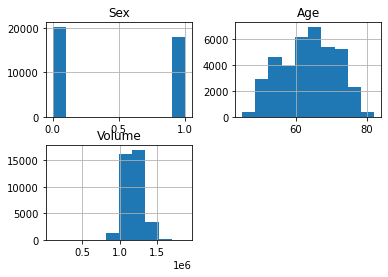

In [7]:
participants.hist()

In [8]:
merged = participants[[lab, lab2, lab3]].merge(ukb_emb, left_index=True, right_index=True)
# UKB latent space analysis

In [9]:
embeddings = merged.iloc[:,3:]
label = merged.iloc[:,0:3]
label_random = label.copy()
label_random[:] = label_random.sample(frac=1).values
# print(embeddings.head())
print(label.head())
print(label_random.head())

             Sex   Age     Volume
sub-3411469    1  65.0  1136465.0
sub-2290292    0  69.0  1079118.0
sub-3842391    0  70.0  1124077.0
sub-2758537    1  49.0  1246758.0
sub-4334619    1  70.0  1410387.0
             Sex   Age     Volume
sub-3411469  0.0  53.0  1234135.0
sub-2290292  1.0  72.0  1303058.0
sub-3842391  0.0  65.0  1250446.0
sub-2758537  0.0  57.0  1187217.0
sub-4334619  1.0  63.0  1223831.0


In [10]:
# Construct nearest_neighbor matrix
nbrs = NearestNeighbors(n_neighbors=2000, algorithm='brute').fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)
indices.shape

(37715, 2000)

In [11]:
distances_hcp, indices_hcp = nbrs.kneighbors(embeddings_hcp)
distances_imagen, indices_imagen = nbrs.kneighbors(embeddings_imagen)

In [12]:
def construct_average_nearest_neighbors(label, indices=indices):
    # Takes list of incides whose label is 1
    label_red = label.reset_index().iloc[:,[1]]
    label_1 = label_red[label_red.iloc[:,0]==1].index.to_list()
    
    # In the indices matrix, put value of label corresponding to index
    neighbors = indices[:,1:]
    labels1 = np.in1d(neighbors, label_1)
    labels1 = labels1.reshape(neighbors.shape).astype(int)
    
    # Makes moving average along nearest neighbor
    labels1_cum = np.cumsum(labels1, axis=1)
    means_npy = np.zeros(labels1_cum.shape)
    for idx in range(len(labels1)):
        means_npy[idx,:] = labels1_cum[idx,:]/(np.arange(1, labels1_cum.shape[1]+1, 1).reshape(1,-1))
        
    return labels1, means_npy

In [13]:
def construct_average_nearest_neighbors_continuous(label, indices=indices):
    label_red = label.reset_index().iloc[:,[1]].values

    # In the indices matrix, put value of label corresponding to index
    neighbors = indices[:,1:]
    labels1 = np.zeros(neighbors.shape)
    for idx in range(len(neighbors)):
        for j in range(neighbors.shape[1]):
            labels1[idx, j] = label_red[neighbors[idx, j]]
    
    # Makes moving average along nearest neighbor
    labels1_cum = np.cumsum(labels1, axis=1)
    
    means_npy = np.zeros(labels1_cum.shape)
    for idx in range(len(labels1)):
        means_npy[idx,:] = labels1_cum[idx,:]/(np.arange(1, labels1_cum.shape[1]+1, 1).reshape(1,-1))
        
    return labels1, means_npy

In [14]:
def construct_average_distance_nearest_neighbors(distances=distances):

    # Makes moving average along nearest neighbor
    distances_cum = np.cumsum(distances[:,1:], axis=1)
    means_distance = np.zeros(distances_cum.shape)
    for idx in range(len(distances)):
        means_distance[idx,:] = distances_cum[idx,:]/(np.arange(1, distances_cum.shape[1]+1, 1).reshape(1,-1))
        
    return means_distance

In [15]:
values_npy, means_npy = construct_average_nearest_neighbors(label.iloc[:,[0]])

In [16]:
values_hcp_npy, means_hcp_npy = construct_average_nearest_neighbors(label.iloc[:,[0]], indices_hcp)
values_imagen_npy, means_imagen_npy = construct_average_nearest_neighbors(label.iloc[:,[0]], indices_imagen)

In [17]:
label_imagen

,Sex,Age
1274,0,15.032877
75717,1,14.780822
106601,1,13.967123
106871,0,15.671233
112288,1,14.416438
...,...,...
99873252,0,14.841096
99875982,0,14.320548
99888850,1,14.942466
99930021,0,15.065753


In [18]:
values2_hcp_npy, means2_hcp_npy = construct_average_nearest_neighbors_continuous(label.iloc[:,[1]], indices_hcp)
values2_imagen_npy, means2_imagen_npy = construct_average_nearest_neighbors_continuous(label.iloc[:,[1]], indices_imagen)

/tmp/ipykernel_788262/1831665505.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels1[idx, j] = label_red[neighbors[idx, j]]


In [19]:
values3_hcp_npy, means3_hcp_npy = construct_average_nearest_neighbors_continuous(label.iloc[:,[2]], indices_hcp)
values3_imagen_npy, means3_imagen_npy = construct_average_nearest_neighbors_continuous(label.iloc[:,[2]], indices_imagen)

/tmp/ipykernel_788262/1831665505.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels1[idx, j] = label_red[neighbors[idx, j]]


In [20]:
values2_npy, means2_npy = construct_average_nearest_neighbors_continuous(label.iloc[:,[1]])

/tmp/ipykernel_788262/1831665505.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels1[idx, j] = label_red[neighbors[idx, j]]


In [21]:
values3_npy, means3_npy = construct_average_nearest_neighbors_continuous(label.iloc[:,[2]])

/tmp/ipykernel_788262/1831665505.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels1[idx, j] = label_red[neighbors[idx, j]]


In [22]:
val_random_npy, random_npy = construct_average_nearest_neighbors(label_random.iloc[:,[0]])

In [23]:
val2_random_npy, random2_npy = construct_average_nearest_neighbors_continuous(label_random.iloc[:,[1]])
val3_random_npy, random3_npy = construct_average_nearest_neighbors_continuous(label_random.iloc[:,[2]])

/tmp/ipykernel_788262/1831665505.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels1[idx, j] = label_red[neighbors[idx, j]]


(array([  3.,   6.,  16.,  30.,  44.,  61., 114., 134., 165., 177., 123.,
         91.,  59.,  42.,  19.,  20.,   4.,   3.,   2.,   1.]),
 array([ 92.31596027, 100.552859  , 108.78975773, 117.02665645,
        125.26355518, 133.50045391, 141.73735263, 149.97425136,
        158.21115009, 166.44804882, 174.68494754, 182.92184627,
        191.158745  , 199.39564372, 207.63254245, 215.86944118,
        224.1063399 , 232.34323863, 240.58013736, 248.81703608,
        257.05393481]),
 <BarContainer object of 20 artists>)

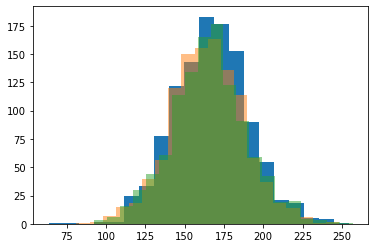

In [24]:
plt.hist(distances[:1114,1], bins=20)
plt.hist(distances_hcp[:,0], alpha=0.5, bins=20)
plt.hist(distances_imagen[:1114,0], alpha=0.5, bins=20)

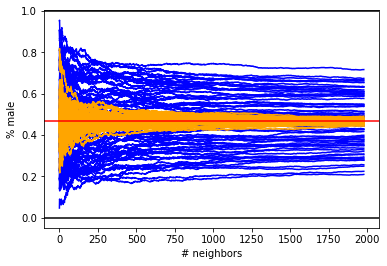

In [80]:
for idx in range(1,35000,500):
    plt.plot(means_npy[idx, 20:], color='b')
for idx in range(1,35000,500):
    plt.plot(random_npy[idx, 20:], color='orange')
plt.axhline(y=np.mean(label[lab].values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.xlabel("# neighbors")
plt.ylabel("% male")
plt.show()

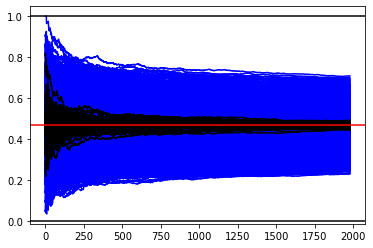

In [26]:
for idx in range(1,1000,1):
    plt.plot(means_hcp_npy[idx, 20:], color='b')
for idx in range(1,35000,500):
    plt.plot(random_npy[idx, 20:], color='black')
plt.axhline(y=np.mean(label[lab].values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.show()

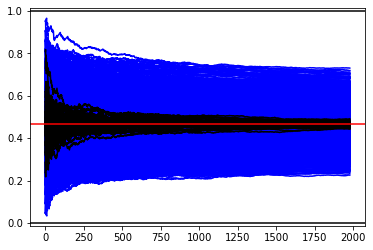

In [27]:
for idx in range(1,1000,1):
    plt.plot(means_imagen_npy[idx, 20:], color='b')
for idx in range(1,35000,500):
    plt.plot(random_npy[idx, 20:], color='black')
plt.axhline(y=np.mean(label[lab].values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.show()

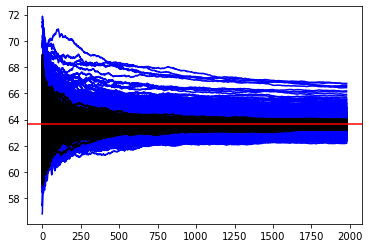

In [28]:
for idx in range(1,35000,50):
    plt.plot(means2_npy[idx, 20:], color='b')
for idx in range(1,35000,50):
    plt.plot(random2_npy[idx, 20:], color='black')
plt.axhline(y=np.mean(label[lab2].values), color='r', linestyle='-')
plt.show()

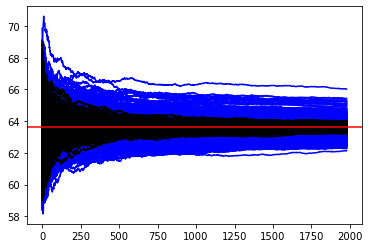

In [29]:
for idx in range(1,1000,1):
    plt.plot(means2_hcp_npy[idx, 20:], color='b')
for idx in range(1,35000,50):
    plt.plot(random2_npy[idx, 20:], color='black')
plt.axhline(y=np.mean(label[lab2].values), color='r', linestyle='-')
plt.show()

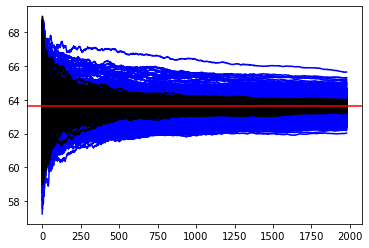

In [30]:
for idx in range(1,1000,1):
    plt.plot(means2_imagen_npy[idx, 20:], color='b')
for idx in range(1,35000,50):
    plt.plot(random2_npy[idx, 20:], color='black')
plt.axhline(y=np.mean(label[lab2].values), color='r', linestyle='-')
plt.show()

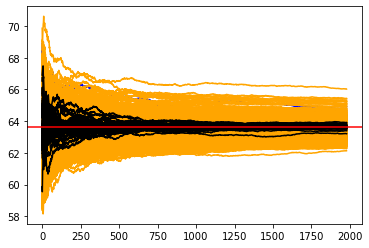

In [31]:
for idx in range(1,35000,1000):
    plt.plot(means2_npy[idx, 20:], color='b')
for idx in range(1,1000,1):
    plt.plot(means2_hcp_npy[idx, 20:], color='orange')
for idx in range(1,35000,1000):
    plt.plot(random2_npy[idx, 20:], color='black')
plt.axhline(y=np.mean(label[lab2].values), color='r', linestyle='-')
plt.show()

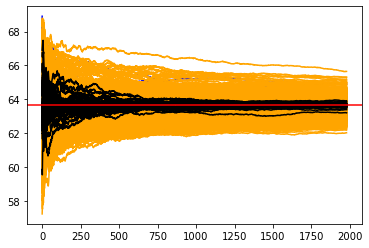

In [32]:
for idx in range(1,35000,1000):
    plt.plot(means2_npy[idx, 20:], color='b')
for idx in range(1,1000,1):
    plt.plot(means2_imagen_npy[idx, 20:], color='orange')
for idx in range(1,35000,1000):
    plt.plot(random2_npy[idx, 20:], color='black')
plt.axhline(y=np.mean(label[lab2].values), color='r', linestyle='-')
plt.show()

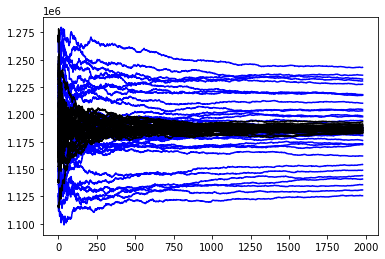

In [52]:
for idx in range(1,35000,1000):
    plt.plot(means3_npy[idx, 20:], color='b')
for idx in range(1,35000,1000):
    plt.plot(random3_npy[idx, 20:], color='black')
# plt.axhline(y=np.mean(label[lab2].values), color='r', linestyle='-')
plt.show()

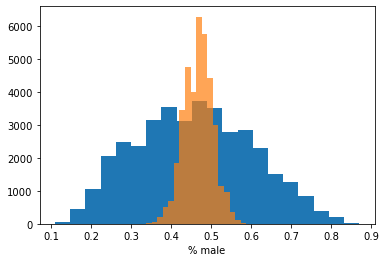

In [78]:
nb_neighbors=200
plt.hist(means_npy[:, nb_neighbors], bins=20)
plt.hist(random_npy[:, nb_neighbors], bins=20, alpha=0.7)
plt.xlabel("% male")
plt.show()

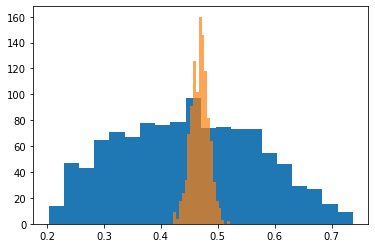

In [35]:
nb_neighbors=1000
plt.hist(means_hcp_npy[:, nb_neighbors], bins=20)
plt.hist(random_npy[:1114, nb_neighbors], bins=20, alpha=0.7)
plt.show()

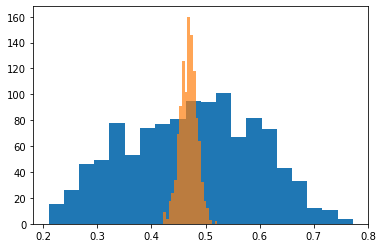

In [36]:
nb_neighbors=1000
plt.hist(means_imagen_npy[:1114, nb_neighbors], bins=20)
plt.hist(random_npy[:1114, nb_neighbors], bins=20, alpha=0.7)
plt.show()

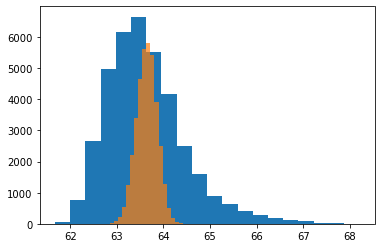

In [37]:
nb_neighbors=1000
plt.hist(means2_npy[:, nb_neighbors], bins=20)
plt.hist(random2_npy[:, nb_neighbors], bins=20, alpha=0.7)
plt.show()

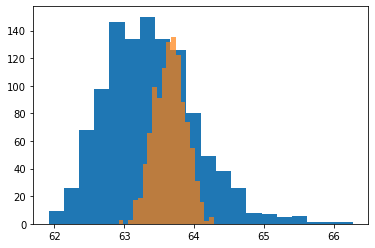

In [38]:
nb_neighbors=1000
plt.hist(means2_hcp_npy[:, nb_neighbors], bins=20)
plt.hist(random2_npy[:1114, nb_neighbors], bins=20, alpha=0.7)
plt.show()

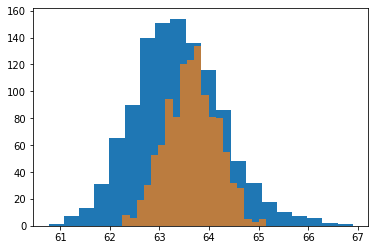

In [64]:
nb_neighbors=200
plt.hist(means2_imagen_npy[:1114, nb_neighbors], bins=20)
plt.hist(random2_npy[:1114, nb_neighbors], bins=20, alpha=0.7)
plt.show()

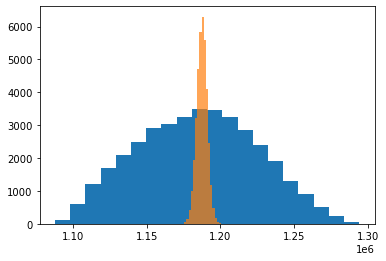

In [40]:
nb_neighbors=1000
plt.hist(means3_npy[:, nb_neighbors], bins=20)
plt.hist(random3_npy[:, nb_neighbors], bins=20, alpha=0.7)
plt.show()

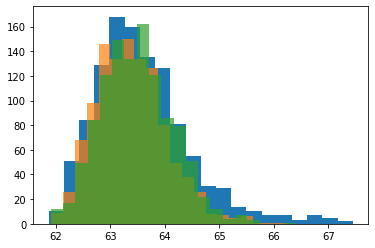

In [41]:
nb_neighbors=1000
plt.hist(means2_npy[:1114, nb_neighbors], bins=20)
plt.hist(means2_hcp_npy[:, nb_neighbors], bins=20, alpha=0.7)
plt.hist(means2_imagen_npy[:1114, nb_neighbors], bins=20, alpha=0.7)
plt.show()

Text(0, 0.5, 'Age')

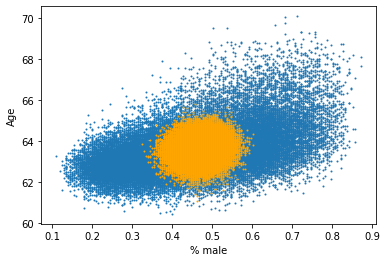

In [60]:
nb_neighbors=200
plt.scatter(means_npy[:, nb_neighbors], means2_npy[:, nb_neighbors], s=1)
plt.scatter(random_npy[:, nb_neighbors], random2_npy[:, nb_neighbors], s=1, c='orange')
plt.xlabel("% male")
plt.ylabel("Age")

Text(0, 0.5, 'Volume')

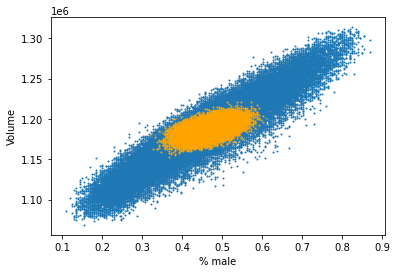

In [63]:
nb_neighbors=200
plt.scatter(means_npy[:, nb_neighbors], means3_npy[:, nb_neighbors], s=1)
plt.scatter(random_npy[:, nb_neighbors], random3_npy[:, nb_neighbors], s=1, c='orange')
plt.xlabel("% male")
plt.ylabel("Volume")

In [67]:
means3_npy.min()

350216.0

Text(0, 0.5, 'Volume')

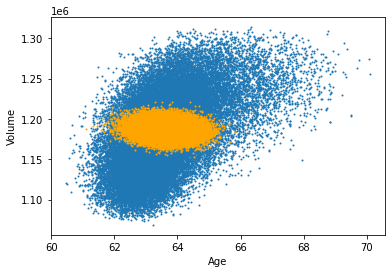

In [61]:
nb_neighbors=200
plt.scatter(means2_npy[:, nb_neighbors], means3_npy[:, nb_neighbors], s=1)
plt.scatter(random2_npy[:, nb_neighbors], random3_npy[:, nb_neighbors], s=1, c='orange')
plt.xlabel("Age")
plt.ylabel("Volume")

In [45]:
label_w = label.reset_index()
label_w_hcp = label_hcp.reset_index()
label_w_imagen = label_imagen.reset_index()
label_w_hcp
# label_w_hcp[label_w_hcp.Sex==0].index.to_list()

,index,Sex,Age
0,100206,1,27
1,100307,0,27
2,100408,1,33
3,100610,1,27
4,101006,0,35
...,...,...,...
1108,992774,1,35
1109,993675,0,29
1110,994273,1,30
1111,995174,1,25


In [46]:
means_hcp_npy.shape

(1113, 1999)

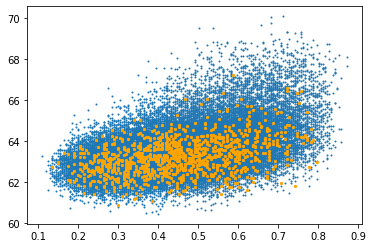

In [70]:
nb_neighbors=200
plt.scatter(means_npy[:, nb_neighbors], means2_npy[:, nb_neighbors], s=1)
plt.scatter(means_hcp_npy[label_w_hcp[label_w_hcp.Sex==0].index.to_list(), nb_neighbors],
            means2_hcp_npy[label_w_hcp[label_w_hcp.Sex==0].index.to_list(), nb_neighbors], s=5, c='orange')
plt.scatter(means_hcp_npy[label_w_hcp[label_w_hcp.Sex==1].index.to_list(), nb_neighbors],
            means2_hcp_npy[label_w_hcp[label_w_hcp.Sex==1].index.to_list(), nb_neighbors], s=5, c='orange')

(60.0, 71.0)

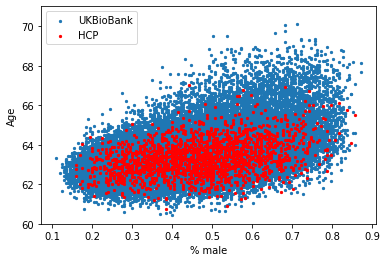

In [88]:
nb_neighbors=200
plt.scatter(means_npy[:, nb_neighbors], means2_npy[:, nb_neighbors], s=5, label="UKBioBank")
plt.scatter(means_imagen_npy[:, nb_neighbors], means2_imagen_npy[:, nb_neighbors], s=5, c="red", label="HCP")
plt.xlabel("% male")
plt.ylabel("Age")
plt.legend()
plt.ylim((60,71))

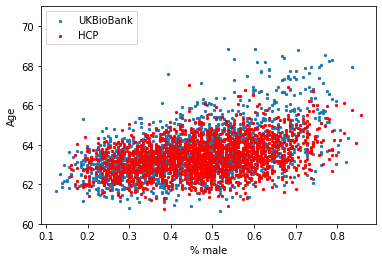

In [92]:
nb_neighbors=200
plt.scatter(means_npy[:2000, nb_neighbors], means2_npy[:2000, nb_neighbors], s=5, label="UKBioBank")
plt.scatter(means_imagen_npy[:2000, nb_neighbors], means2_imagen_npy[:2000, nb_neighbors], s=5, c="red", label="HCP")
plt.xlabel("% male")
plt.ylabel("Age")
plt.ylim((60,71))
plt.legend(loc="upper left")

(array([ 404., 2488., 3383., 3622., 3643., 2915., 2083., 1115.,  390.,
          62.]),
 array([0.16183816, 0.22347652, 0.28511489, 0.34675325, 0.40839161,
        0.47002997, 0.53166833, 0.59330669, 0.65494505, 0.71658342,
        0.77822178]),
 <BarContainer object of 10 artists>)

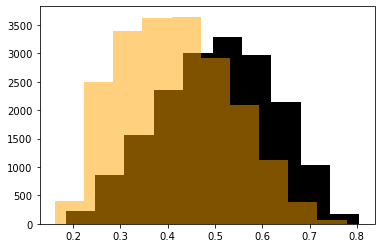

In [49]:
plt.hist(means_npy[label_w[label_w.Sex==1].index.to_list(), nb_neighbors], color='black')
plt.hist(means_npy[label_w[label_w.Sex==0].index.to_list(), nb_neighbors], color='orange', alpha=0.5)

(array([ 53.,  74.,  91.,  85., 109.,  79.,  51.,  40.,  15.,   9.]),
 array([0.2027972 , 0.25484515, 0.30689311, 0.35894106, 0.41098901,
        0.46303696, 0.51508492, 0.56713287, 0.61918082, 0.67122877,
        0.72327672]),
 <BarContainer object of 10 artists>)

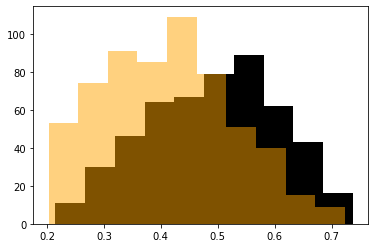

In [50]:
plt.hist(means_hcp_npy[label_w_hcp[label_w_hcp.Sex==1].index.to_list(), nb_neighbors], color='black')
plt.hist(means_hcp_npy[label_w_hcp[label_w_hcp.Sex==0].index.to_list(), nb_neighbors], color='orange', alpha=0.5)

(array([ 48., 113., 148., 128., 159., 157., 121.,  74.,  27.,   6.]),
 array([0.20679321, 0.26053946, 0.31428571, 0.36803197, 0.42177822,
        0.47552448, 0.52927073, 0.58301698, 0.63676324, 0.69050949,
        0.74425574]),
 <BarContainer object of 10 artists>)

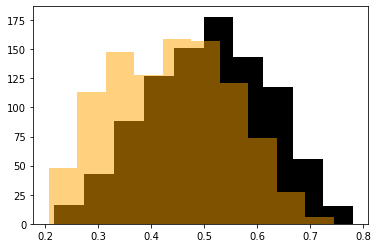

In [51]:
plt.hist(means_imagen_npy[label_w_imagen[label_w_imagen.Sex==1].index.to_list(), nb_neighbors], color='black')
plt.hist(means_imagen_npy[label_w_imagen[label_w_imagen.Sex==0].index.to_list(), nb_neighbors], color='orange', alpha=0.5)